# How to produce create 3D plots

To view the structure, there are several options available in OpenModes. A split ring geometry is loaded, and the a plane-wave excitation is used to give a solution to plot

In [1]:
# the numpy library contains useful mathematical functions
import numpy as np

# import useful python libraries
import os.path as osp
import sys

# import the openmodes packages
import openmodes
from openmodes.constants import eta_0
from openmodes.sources import PlaneWaveSource

# Imports for plotting and image display
from IPython.display import Image, display
%matplotlib inline

from warnings import warn

A simulation object named `sim` is created to manage the simulation. This gives us convenient access to most of the plotting functions.

In [2]:
sim = openmodes.Simulation(notebook=True)

filename = osp.join(openmodes.geometry_dir, "SRR.geo")
mesh_tol = 1e-3
outer_radius = 4e-3
srr = sim.load_mesh(filename, mesh_tol, parameters={'inner_radius': 2.5e-3, 'outer_radius': outer_radius})

ring1 = sim.place_part(srr)
ring2 = sim.place_part(srr)
ring2.rotate(axis = [0, 0, 1], angle = 180)
ring2.translate([0, 0, 2e-3])

# construct the source plane wave with given polarisation and propagation direction
e_inc = np.array([0, 1, 0])
k_dir = np.array([1, 0, 0])
plane_wave = PlaneWaveSource(e_inc, k_dir)

# solve the currents for one frequency
s = 2j*np.pi*4e9
Z = sim.impedance(s)
V = sim.source_vector(plane_wave, s)
I = Z.solve(V)

## 1. In browser interactive plot with webgl

This option is the most convenient for interactive use, and it is the default. A 3D plot will appear inside the web browser, including controls to change the quanitity plotted, and with mouse controls to zoom, pan etc.

In theory this should work in any modern web browser, but it has been most extensively tested under google chrome. If this does not work, then try upgrading your web browser and then your graphics card drivers. 

This option is the preferred approach, even though it is somewhat experimental. Note that it is based on a javascript webgl animation loop, so CPU usage may be high even just to view the plot.

Before plotting this way, you should have passed `notebook=True` when creating the `Simulation` object.


In [3]:
sim.plot_3d(solution=I["J", :])#, output_format='webgl')#, compress_scalars=5)

## 2. Generating a VTK file for external tools

Another option is to plot to a `.vtk` file. This is a common format for 3D visualisation of scientific plots. This file format can be read by the prgrams [Paraview](http://www.paraview.org/) or [VisIt](https://wci.llnl.gov/simulation/computer-codes/visit).

This method is not convenient for interactive use, since an external program must be used to view the plots. However, these software packages are very flexible and are well-suited to producing publication quality figures.

Note that the libraries for generating .vtk files are incompatible with Python 3.x, so Python 2.7 should be used

To generate such a file, use the `sim.plot_3d` function with the option `output_format='vtk'`.

In [4]:
# make sure the output directory exists
if not osp.exists('output'):
    os.makedirs('output')

sim.plot_3d(solution=I, output_format='vtk', filename=osp.join('output', 'bcsrr-planewave.vtp'))

The image below was manually generated using ParaView, so it must be manually recreated if you re-run this notebook. The colour gives the charge distribution, and the cones gives the current distribution

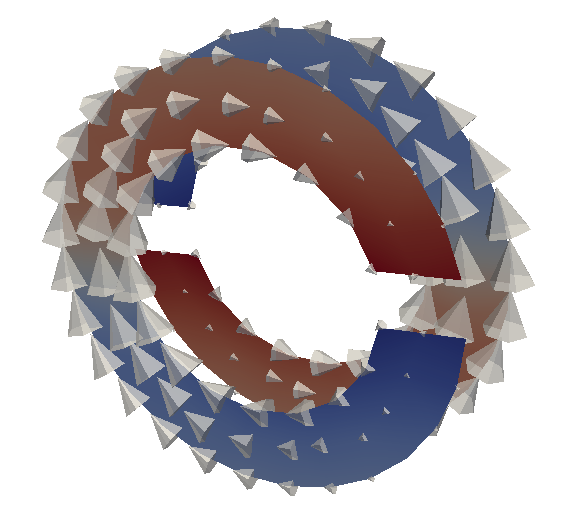

In [5]:
image_file = osp.join('output', 'bcsrr-planewave.png')
if osp.exists(image_file):
    i = Image(image_file, width=400)
    display(i)
else:
    warn("The 3D VTK files can be viewed in the programs Paraview or Visit.\n"
         "To view them in the web browser, please use these programs to export in .png format to `%s`" % image_file)

## 3. Static in-browser matplotlib

The simplest option is to use a pseudo 3-dimensional in-browser plot. This gives a quick check on the geometry, although the automatic scaling of the axes may.

Note that for the plots to appear in the browser, the ipython magic command `%matplotlib inline` is needed in the notebook.

Also, this approach can only show the geometry, it *cannot show the charge or current*.

After importing the function `plot_parts`, just pass it the geomtry to plot. Passing `sim.parts` will plot everything added to the simulation.

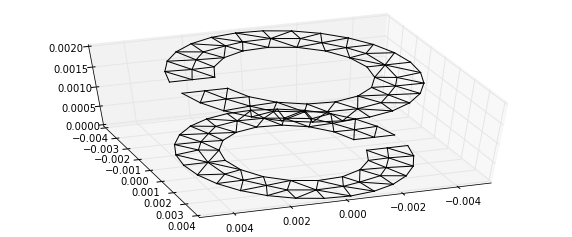

In [6]:
from openmodes.visualise import plot_parts
plot_parts(sim.parts, view_angles=(50, 70))

## 4. Interacitve 3D plot with MayaVi

A more interactive 3D plot can be obtained using the `Mayavi` python plotting library. This is essentially a wrapper around the VTK library. The image will display in a separate window (note that this window may not automatically come to the foreground).

Note that with default setttings, you **cannot interaction with the ipython notebook until this plot is closed**.

**Unfortunately Mayavi is incompatible with Python 3.x, so this approach is deprecated.**

In [7]:
try:
    sim.plot_3d(solution=I["J"], output_format='mayavi', compress_scalars=5)
except ImportError:
    warn("Failed to load Mayavi")

WARNING - 2016-01-25 16:59:47,861 - DEPRECATED: traits.has_traits.wrapped_class, 'the 'implements' class advisor has been deprecated. Use the 'provides' class decorator.
C:\Users\dap124\Miniconda64\envs\py27\lib\site-packages\IPython\kernel\__main__.py:4: UserWarning: Failed to load Mayavi


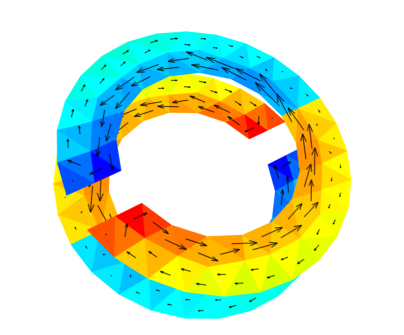

In [8]:
image_file = osp.join('output', 'bcsrr-planewave-mayavi.png')
if osp.exists(image_file):
    i = Image(image_file, width=400)
    display(i)
else:
    warn("To view the screen-shot in browser, save the mayavi view to export in .png format to `%s`" % image_file)

## 5. Options for the `plot_3d` function

- `output_format` chooses what format of plot to produce
- `filename` chooses the file to write to, for plot types such as VTK that write to a file
- `compress_scalars` Because charge solutions tend to diverge at sharp edges, it is often difficult to see the rest of the charge distribution. By setting this option, some compression will be applied, which smoothes out the extremes
- `compress_separately` If some parts have very weak excitation, setting this option will enable their charges and currents to be seen, by removing differences between parts.
- `part` if specified, only a particular part (and all its sub-parts) will be plotted, otherwise all parts in the simulation will be used (or the parts cover by `solution`)